In [1]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn
from torch import optim
from torchsummary import summary
from tqdm import trange
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from  pytorch_lightning import seed_everything
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

seed_everything(42)

Seed set to 42


42

In [2]:
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')

        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict

___
### Исходный датафрейм

In [3]:
FILE_PATH = 'data/hackaton_result_dataset.xlsx'

df = pd.read_excel(FILE_PATH)
y = df['label']
df[:3]

,model_annotation,human_markup,audio_path,label
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,s3://ap-training-set/xacaton_openstt/part_1/05...,1
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,s3://ap-training-set/xacaton_openstt/part_1/05...,0
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,s3://ap-training-set/xacaton_openstt/part_1/05...,0


## Natasha

In [4]:
from navec import Navec
from slovnet.model.emb import NavecEmbedding

In [5]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
navec = Navec.load(path)

In [6]:
import numpy as np
def text_to_average_embedding(text):
    # your code here
    words = text.split()
    valid_embeddings = [navec[word] for word in words if word in navec]
    if not valid_embeddings:
        return np.zeros(300)
    embedding_for_text = np.mean(valid_embeddings, axis=0)
    return embedding_for_text

In [7]:
X_emb = [text_to_average_embedding(text) for text in df['model_annotation']]

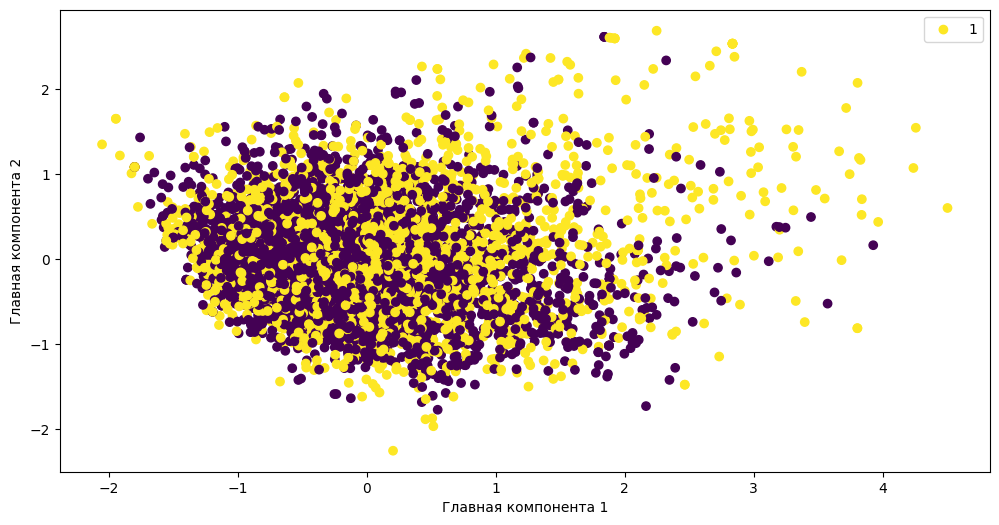

In [8]:
#визуализация 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_emb)
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.legend(y)
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.show()

In [9]:
#Разделение данных


X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.1,stratify=y )

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import scikitplot as skplt

n_estimators = range(50,150,10)
depth = range(1,15)
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': n_estimators,  # Number of trees in the forest
    'max_depth' : depth
    
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_jobs = -1)


grid_search = GridSearchCV(rf, param_grid, cv=StratifiedKFold(5), scoring='roc_auc',)
grid_search.fit(X_train, y_train)


y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)

best_param_dec_tree = grid_search.best_params_


f1_score = metrics.f1_score(y_test, y_pred, average='macro')
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Test F1 score:", f1_score)
print("Test accuracy:", accuracy)


Test F1 score: 0.6059857003869041
Test accuracy: 0.6712749615975423


In [11]:
best_param_dec_tree

{'max_depth': 13, 'n_estimators': 140}

{'RandomForest_Natasha_train': 0.9965393703464454,
 'RandomForest_Natasha_test': 0.6929855585028}

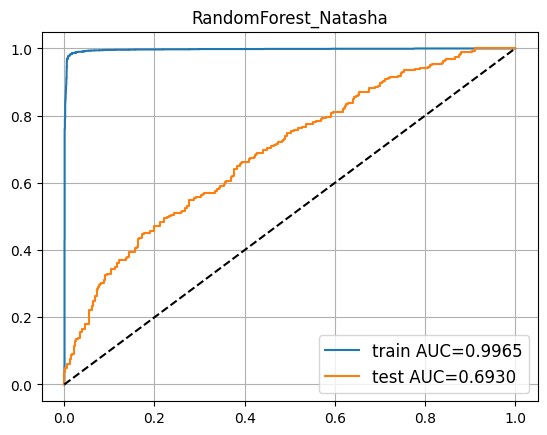

In [12]:
out_dict = {}
out_dict = visualize_and_save_results(grid_search, 'RandomForest_Natasha', X_train, X_test, y_train, y_test, out_dict)
out_dict

C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'log_reg_natasha_elnet_train': 0.694420287919336,
 'log_reg_natasha_elnet_test': 0.6690834070144415}

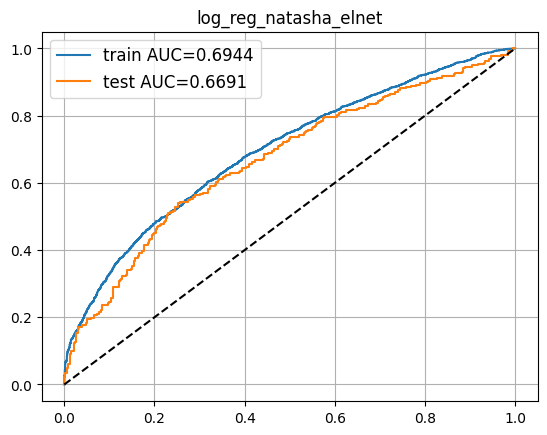

In [13]:
lr = LogisticRegression()

param_grid = {'penalty': ['elasticnet','l1','l2'],
                'solver':['saga'],
                'max_iter': [  7 ],
                'C': [ 0.001, 0.01, 0.1, 1, 10, 100],  
                'l1_ratio':[0.8, 0.9, 1]}
gs = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2)
gs.fit(X_train, y_train)
best_params_log_reg = gs.best_params_

out_dict = {}
out_dict = visualize_and_save_results(gs, 'log_reg_natasha_elnet', X_train, X_test, y_train, y_test, out_dict)
out_dict

[LightGBM] [Warning] 0.1 is set=, 0.1= will be ignored. Current value: 0.1=
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] 0.1 is set=, 0.1= will be ignored. Current value: 0.1=
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 2345, number of negative: 3512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 5857, number of used features:

{'lgbm_natasha_train': 0.8634787946049123,
 'lgbm_natasha_test': 0.699508792612241}

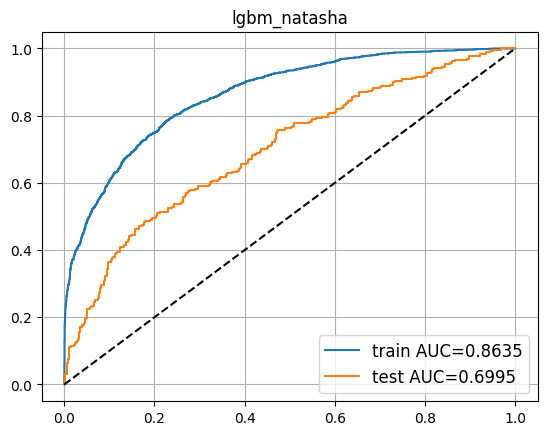

In [14]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


lgbm = LGBMClassifier(objective='binary')

param_grid = {
            'boosting_type':['gbdt'],
            'max_depth': [1,2,3],
            'reg_alpha ':[0.1, 0.5],
            'reg_lambda ':[0.1, 0.5],
            'n_estimators' :[300]
            }

gs = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2)

gs.fit(X_train, y_train)


out_dict = {}
out_dict = visualize_and_save_results(gs, 'lgbm_natasha', X_train, X_test, y_train, y_test, out_dict)
out_dict

Best parameters: {'max_depth': 2}
Best cross-validation F1 score: 0.5890129332391705
[LightGBM] [Warning] 0.1 is set=, 0.1= will be ignored. Current value: 0.1=
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] 0.1 is set=, 0.1= will be ignored. Current value: 0.1=
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] Unknown parameter: 0.1


{'des_natasha_train': 0.8634787946049123,
 'des_natasha_test': 0.699508792612241}

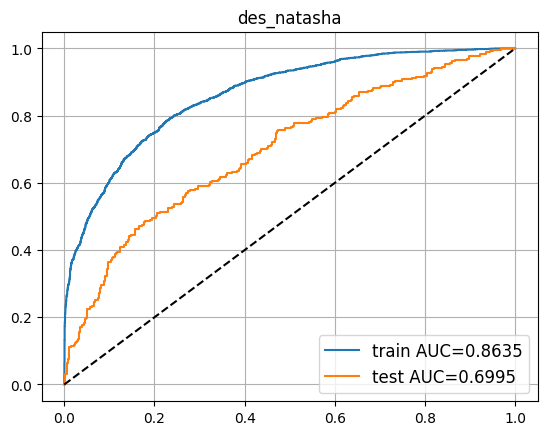

In [15]:
from sklearn.tree import DecisionTreeClassifier

# YOUR CODE HERE

from sklearn.model_selection import GridSearchCV
from sklearn import metrics


param_grid = {
    'max_depth': np.arange(2, 101, 5)
}


decision_tree = DecisionTreeClassifier(random_state=42)


grid_search = GridSearchCV(decision_tree, param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

best_param_dec_tree = grid_search.best_params_



out_dict = {}
out_dict = visualize_and_save_results(gs, 'des_natasha', X_train, X_test, y_train, y_test, out_dict)
out_dict

C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'bagging_dt_natasha_train': 0.6574479943270953,
 'bagging_dt_natasha_test': 0.6417477158856469}

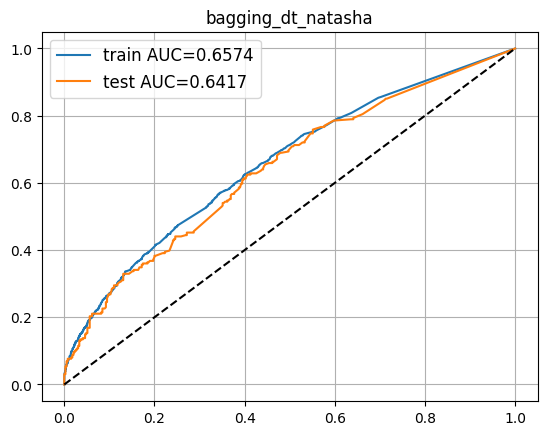

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier



N = 10 #размер ансамбля
    



decision_tree = DecisionTreeClassifier(**best_param_dec_tree, random_state=42)
bagging_dt = BaggingClassifier(base_estimator=decision_tree, n_estimators=N, random_state=42)
bagging_dt.fit(X_train, y_train)





out_dict = {}
out_dict = visualize_and_save_results(bagging_dt, 'bagging_dt_natasha', X_train, X_test, y_train, y_test, out_dict)
out_dict

C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\li

{'bagging_lr_natasha_train': 0.6953698194675824,
 'bagging_lr_natasha_test': 0.6663424697907457}

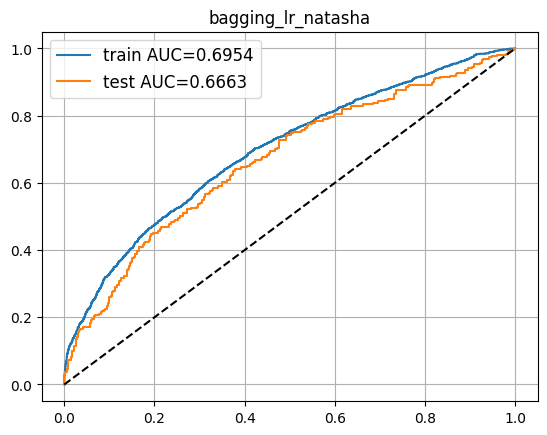

In [17]:
N = 30 #размер ансамбля
    

logistic_regression = LogisticRegression(**best_params_log_reg)
bagging_lr = BaggingClassifier(base_estimator=logistic_regression, n_estimators=N, random_state=42)
bagging_lr.fit(X_train, y_train)


out_dict = {}
out_dict = visualize_and_save_results(bagging_lr, 'bagging_lr_natasha', X_train, X_test, y_train, y_test, out_dict)
out_dict

In [68]:
from kan import *
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device =  torch.device('cpu')

In [70]:
device

device(type='cpu')

In [69]:
dataset = {}


dataset['train_input'] = torch.tensor(X_train, dtype=torch.float32).to(device)
dataset['test_input'] =  torch.tensor(X_test, dtype=torch.float).to(device)
dataset['train_label'] = torch.tensor(y_train.values, dtype=torch.float32).to(device)
dataset['test_label'] = torch.tensor(y_test.values, dtype=torch.float32).to(device)


In [71]:

model = KAN(width=[300,10,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])) == dataset['test_label']).float())

results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

train loss: 4.90e-01 | test loss: 4.90e-01 | reg: 5.72e+01 : 100%|██| 20/20 [19:45<00:00, 59.28s/it]


In [72]:
results

{'train_loss': [array(0.49019033, dtype=float32),
  array(0.49000022, dtype=float32),
  array(0.48998505, dtype=float32),
  array(0.48997876, dtype=float32),
  array(0.48997682, dtype=float32),
  array(0.4899754, dtype=float32),
  array(0.48997536, dtype=float32),
  array(0.48997515, dtype=float32),
  array(0.48997515, dtype=float32),
  array(0.48997515, dtype=float32),
  array(0.48997515, dtype=float32),
  array(0.48997512, dtype=float32),
  array(0.4899751, dtype=float32),
  array(0.48997512, dtype=float32),
  array(0.4899751, dtype=float32),
  array(0.4899751, dtype=float32),
  array(0.4899751, dtype=float32),
  array(0.48997506, dtype=float32),
  array(0.48997506, dtype=float32),
  array(0.48997506, dtype=float32)],
 'test_loss': [array(0.49028057, dtype=float32),
  array(0.49010795, dtype=float32),
  array(0.49009457, dtype=float32),
  array(0.49008968, dtype=float32),
  array(0.490089, dtype=float32),
  array(0.4900866, dtype=float32),
  array(0.49008653, dtype=float32),
  array(

In [74]:
X_train_emb_torch = torch.tensor(X_train, dtype=torch.float).to(device)
X_test_emb_torch = torch.tensor(X_test, dtype=torch.float).to(device)

y_train_torch = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long).to(device)

In [75]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample batch_size random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch) # your code here
  #      print(y_predicted,y_batch)
        
        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch) # your code here

        # compute gradients
        # your code here
        loss.backward()
        # Adam step
        # your code here
        opt.step()

        # clear gradients
        # your code here
        opt.zero_grad()

        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            #acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            #val_acc_history.append(acc_score_val)

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

In [112]:
class Regress(nn.Module):
    def __init__(self, n_input_features):
        super(Regress, self).__init__()
        self.linear1 = nn.Linear(n_input_features, 10)
        #self.linear2 = nn.Linear(10, 12)
        self.linear3 = nn.Linear(10, 2)
    
    #sigmoid transformation of the input 
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        #x = self.linear2(x)
        #x = torch.relu(x)
        x = self.linear3(x)        
        x = torch.sigmoid(x)
        return x


model = Regress(X_train_emb_torch.shape[1])# your code here

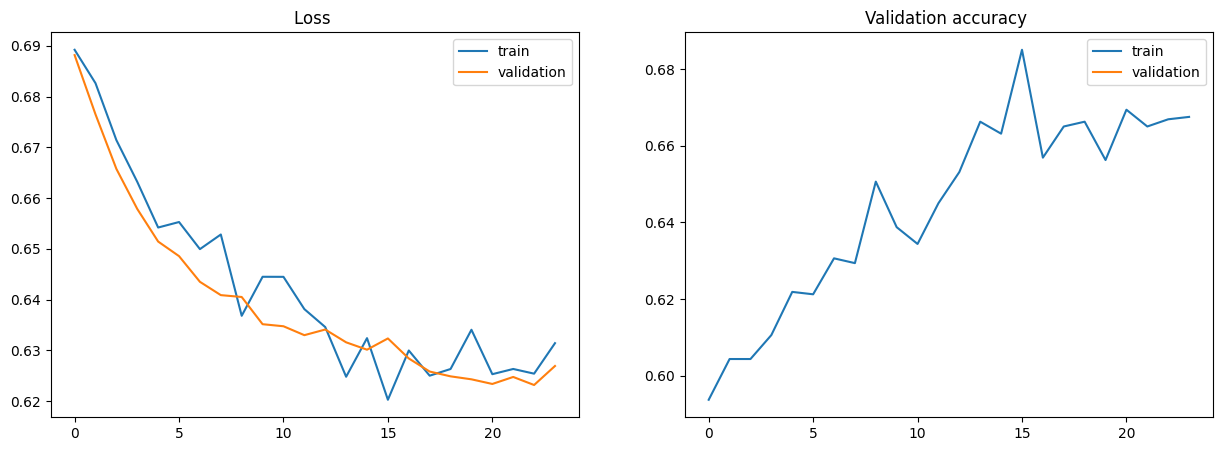

In [113]:
loss_function = nn.CrossEntropyLoss()# your code here
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# your code here

model = train_model(model, opt, X_train_emb_torch, y_train_torch, X_test_emb_torch, y_test_torch, n_iterations=1200)

{'bagging_lr_natasha_train': 0.6953698194675824, 'bagging_lr_natasha_test': 0.6663424697907457, 'emb_nn_torch_train': 0.6861303432398697, 'emb_nn_torch_test': 0.6897239414480795}


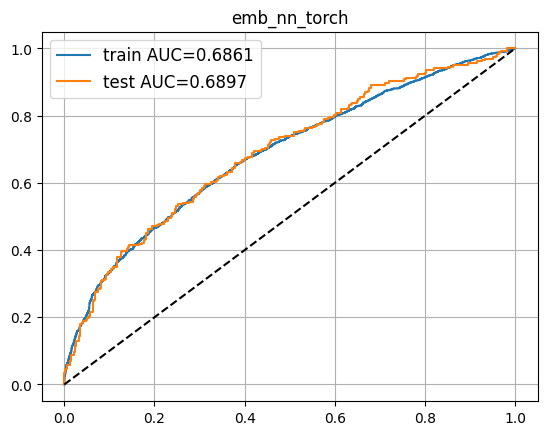

In [114]:
out_dict = visualize_and_save_results(model, 'emb_nn_torch', X_train_emb_torch, X_test_emb_torch, y_train, y_test, out_dict)
print(out_dict)